# Solve Poisson's equation using FFT

$$\nabla^2 \phi = f$$

for 

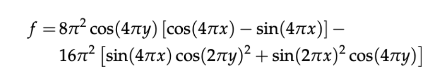

The analytical solution is:


$$\phi = \sin(2\pi x)^2\cos(4\pi y) + \sin(4\pi x)\cos(2\pi y)^2$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## A. Check/plot analytical solution:

In [3]:
# Create an XY grid

# Set number of points
nx = 256
ny = 256

# Min/Max values for the axes
x_min = 0.
x_max = 1.

y_min = 0.
y_max = 1.

# Define step sizes 
dx = (x_max - x_min)/nx
dy = (y_max - y_min)/ny

#print(dx)
#print(dy)

In [4]:
# Create the axes:
x = np.arange(x_min, x_max, dx)
y = np.arange(y_min, y_max, dy)

#print(x.shape, y.shape)

# We create the 2D domain
x_2d, y_2d = np.meshgrid(x, y)

#print(x_2d.shape, y_2d.shape)

#### Create function for the known sln:


$$\phi(x, y) = \sin(2\pi x)^2\cos(4\pi y) + \sin(4\pi x)\cos(2\pi y)^2$$

In [5]:
def exact_sln(xx, yy):
    """
    Function to compute the kown sln.
    Inputs: xx->x_2d, yy->y_2d
    Output: exact sln
    """
    
    phi_exact = (np.sin(2*np.pi*xx)**2)*(np.cos(4*np.pi*yy)) + \
    (np.sin(4*np.pi*xx))*(np.cos(2*np.pi*yy)**2)
    
    return phi_exact 

In [6]:
# Evaluate the function using our 2D grid

z_sln = exact_sln(x_2d, y_2d)

#print(z_sln.shape)

### Plotting the function for $\phi(x,y)$:

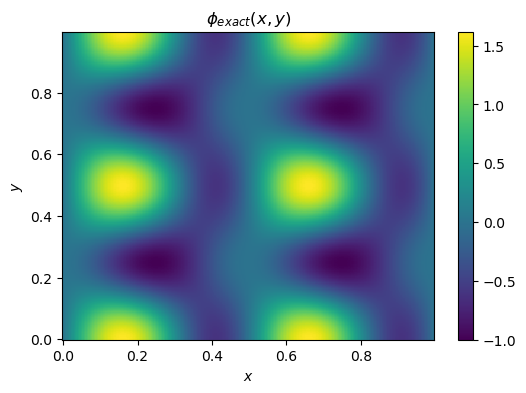

In [7]:
# Figure environment

plt.figure(figsize=(6,4))

surf = plt.pcolor(x_2d, y_2d, z_sln)

plt.colorbar(surf)

plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

plt.title(r"$\phi_{exact}(x,y)$")

plt.show()

In [8]:
from mpl_toolkits.mplot3d import Axes3D

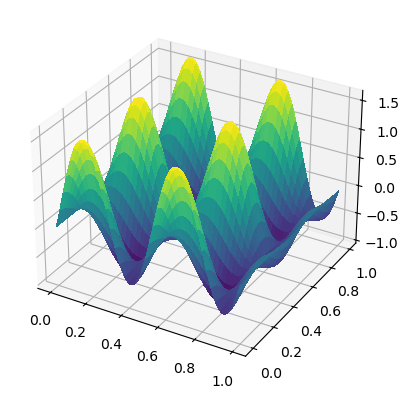

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(x_2d, y_2d, z_sln, \
     cmap = 'viridis', linewidth=0, antialiased=False)

plt.show()

## B. Use FFT method to find the numerical sln:

### 1. Calculate the spatial frequencies ($k_x, k_y$)

In [12]:
# Get the spatial frequencies / wavenumbers

k_x = np.fft.fftfreq(x.size)/dx
k_y = np.fft.fftfreq(y.size)/dy

#print(k_x.size, k_y.size)

#print(k_x)

### 2. Frequency-space meshgrid:

In [13]:
# Create a grid in Fourier space

kx_2d, ky_2d = np.meshgrid(k_x, k_y)

#print(ky_2d)

### 3. Define the function $f(x,y)$

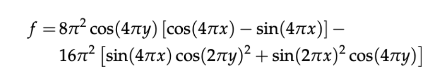

In [14]:
def rhs_function(xx, yy):
    """
    Function to define f(x,y), which is the RHS of the Poission eq.
    Inputs: xx -> x_2d, yy -> y_2d
    Ouput: rhs
    """
    rhs = 8*(np.pi**2)*np.cos(4*np.pi*yy)*(np.cos(4*np.pi*xx)
           - np.sin(4*np.pi*xx)) - 16*(np.pi**2)*(np.sin(4*np.pi*xx)
           *np.cos(2*np.pi*yy)**2 + (np.sin(2*np.pi*xx)**2)
           *np.cos(4*np.pi*yy))
    
    return rhs

In [15]:
# Evaluate this in X, Y

f_xy = rhs_function(x_2d, y_2d)


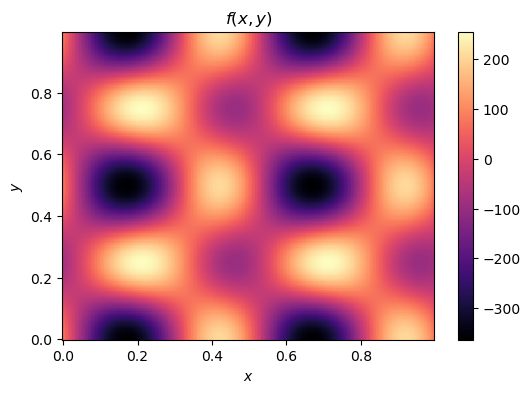

In [16]:
# Figure environment

plt.figure(figsize=(6,4))

f_surf = plt.pcolor(x_2d, y_2d, f_xy, cmap = 'magma')

plt.colorbar(f_surf)

plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

plt.title(r"$f(x,y)$")

plt.show()

### 4. Fast Fourier transform of the function $f(x,y)$:

In [17]:
# We use numpy functions to do the FFT:

f_kk = np.fft.fft2(f_xy)

#print(f_kk)

In [18]:
# Spatial frequencies in Fourier space

kx_2d, ky_2d = np.meshgrid(sorted(k_x), sorted(k_y))


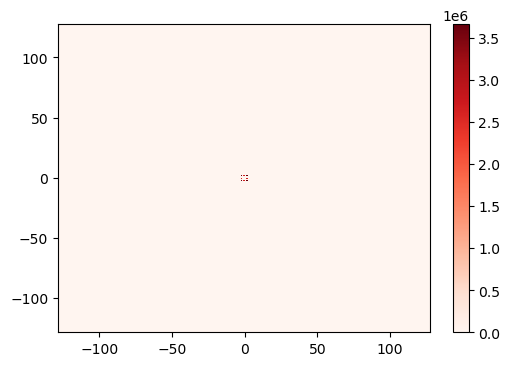

In [19]:
# Figure environment for the Fourier image

plt.figure(figsize=(6,4))

fourier_surf = plt.pcolor(kx_2d, ky_2d,\
               np.abs(np.fft.fftshift(f_kk)), cmap = "Reds")

plt.colorbar(fourier_surf)

plt.show()

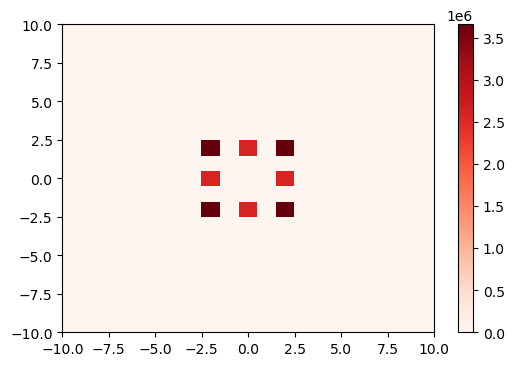

In [20]:
# Figure environment for the Fourier image

plt.figure(figsize=(6,4))

fourier_surf = plt.pcolor(kx_2d, ky_2d,\
               np.abs(np.fft.fftshift(f_kk)), cmap = "Reds")

plt.colorbar(fourier_surf)

plt.xlim(-10, 10)
plt.ylim(-10, 10)

plt.show()

### 5. Get $\Phi_{kk}$ based on eq. 9.16 from Zingale's book:

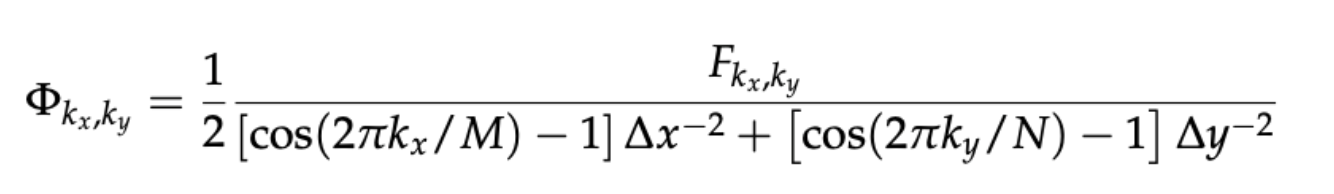

In [21]:
# Unsorted Discrete frequency indices
k_x = np.fft.fftfreq(nx)
k_y = np.fft.fftfreq(ny)
kx_2d, ky_2d = np.meshgrid(k_x, k_y)

In [22]:
# Function to get Phi_kk in FOurier space

def phi_kk(K_XX, K_YY, F_kk):
    
    # Add small epsilon
    eps = 1.e-12

    # Calculate Phi_kk
    denom = ((np.cos(2*np.pi*K_XX) + eps - 1)/dx**2 +
             (np.cos(2*np.pi*K_YY) - 1)/dy**2)
    
    phi_kk_function = 0.5 * F_kk / denom

    # Normalisation step
    # phi_kk_function[0, 0]: Average (mean) value of the entire function
    # DC mode: Fourier coefficient for frequency kx=0, ky = 0 (constant mode).
    phi_kk_function[0, 0] = 0.0  # zero mean
    
    
    # Obsolete
    #phi_kk_function = 0.5*F_kk/((np.cos(2*np.pi*K_XX/nx) + eps - 1)/dx**2\
    #+ (np.cos(2*np.pi*K_YY/ny) - 1)/dy**2)

    
    return phi_kk_function

In [24]:
# Solve in Fourier space: iFFT of phi_kk to get phi in real space 
phi_k_space = phi_kk(kx_2d, ky_2d, f_kk)

# Back to real space
numer_sln = np.real(np.fft.ifft2(phi_k_space))


### 6. Plotting the numerical FFT sln:

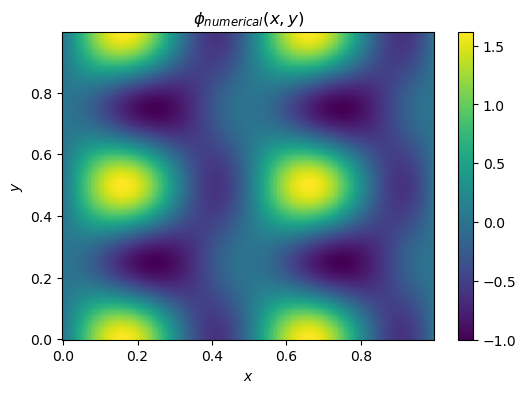

In [25]:
# Figure environment

plt.figure(figsize=(6,4))

A = plt.pcolor(x_2d, y_2d, numer_sln)

plt.colorbar(A)

plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

plt.title(r"$\phi_{numerical}(x,y)$")

plt.show()

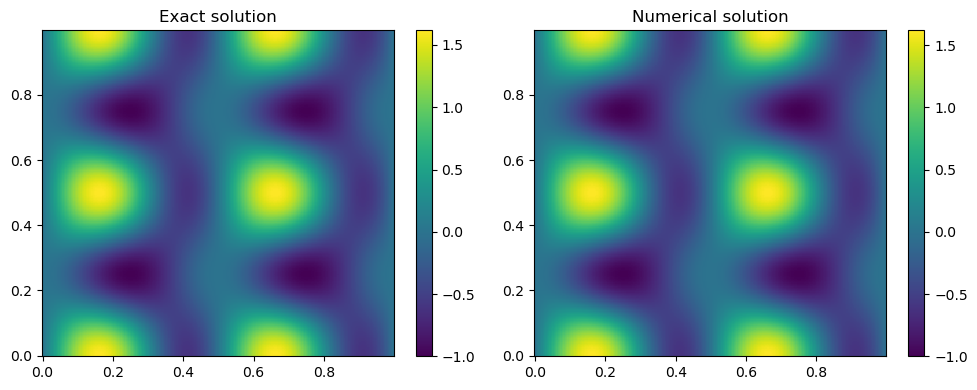

In [26]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
a = ax[0].pcolormesh(x_2d, y_2d, z_sln, cmap='viridis')
fig.colorbar(a, ax=ax[0])
ax[0].set_title("Exact solution")

b = ax[1].pcolormesh(x_2d, y_2d, numer_sln, cmap='viridis')
fig.colorbar(b, ax=ax[1])
ax[1].set_title("Numerical solution")

plt.tight_layout()
plt.show()


### 7. Error analysis:

In [ ]:
# Absolute error map:

# Figure environment

plt.figure(figsize=(6,4))

err_surf = plt.pcolor(x_2d, y_2d, np.abs(numer_sln - z_sln), cmap = "Reds")

plt.colorbar(err_surf)

plt.show()

### $L_2$ norm error:

In [ ]:
# L_2 norm error

#a = np.sum((numer_sln - Z_sln)**2)

L2_error = np.sqrt((np.sum((numer_sln - z_sln)**2)/(nx*ny)))

print("Global L2 Error: ", L2_error)